In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import json
import numpy as np
from torch.utils.data import Dataset, DataLoader
import glob
import wandb
import os
import torch.optim as optimizers
import pandas as pd
from copy import deepcopy
from ml_collections import ConfigDict 
import tqdm
import torch.nn.functional as F
import torch
import torch.nn as nn
from collections import defaultdict
import yaml
from sklearn.metrics import roc_auc_score
import numpy as np

import sys
sys.path.append("../../src")
import dfs_code 
from dfs_transformer import collate_downstream, DFSCodeSeq2SeqFC, Trainer
torch.multiprocessing.set_sharing_strategy('file_system')


In [5]:
graph_file = "../../datasets/karateclub/reddit_threads/reddit_edges.json"
label_file = "../../datasets/karateclub/reddit_threads/reddit_target.csv"
batch_size = 1000

In [6]:
with open(graph_file, 'r') as f:
    graph_dict = json.load(f)
label_df = pd.read_csv(label_file)

In [7]:
label_df.head()

,id,target
0,0,0
1,1,1
2,2,0
3,3,1
4,4,0


In [8]:
label_df['target'].sum()/len(label_df)

0.5124133380603483

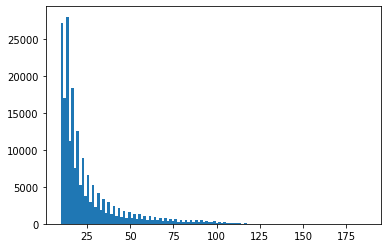

In [9]:
from matplotlib import pyplot as plt
n_edges = [len(graph) for graph in graph_dict.values()]
plt.hist(n_edges, bins='rice')
plt.show()

In [10]:
def graph2labelledgraph(graph):
    graph = deepcopy(graph)
    node_ids = np.unique(graph).tolist()
    dummy = max(node_ids) + 1
    
    edge_labels = len(graph)*[0]
    edgeindex = []
    for e in graph:
        edgeindex += [e]
        edgeindex += [[e[1], e[0]]]
        edge_labels += [0]
    
    edgeindex = np.asarray(edgeindex).T
    
    node_labels = []
    for idx in node_ids:
        node_labels += [(edgeindex[0] == idx).sum()]
    return edgeindex, node_labels, edge_labels

In [11]:
class KarateClubDataset(Dataset):
    def __init__(self, graph_file, label_file, max_n = None, max_edges=110):
        self.graph_file = graph_file
        self.label_file = label_file
        with open(graph_file, 'r') as f:
            self.graph_dict = json.load(f)
        self.label_df = pd.read_csv(label_file)
        self.data = []
        self.maxn = max_n
        self.max_edges = max_edges
        self.preprocess()
    
    def preprocess(self):
        maxn = self.maxn
        maxdegree = 0
        edgeindex_list = []
        vlabels_list = []
        elabels_list = []
        label_list = []
        for idx, (graph, label) in tqdm.tqdm(enumerate(zip(self.graph_dict.values(), self.label_df['target']))):  
            edgeindex, vlabels, elabels = graph2labelledgraph(graph)
            if len(elabels)//2 > self.max_edges:
                continue
            maxdegree = max(maxdegree, max(vlabels))
            edgeindex_list += [edgeindex]
            vlabels_list += [vlabels]
            elabels_list += [elabels]
            label_list += [self.label_df['target'][idx]]
            if maxn is not None:
                if idx >= maxn:
                    break
        self.maxdegree = maxdegree
        
        for idx, (edgeindex, vlabels, elabels, label) in tqdm.tqdm(enumerate(zip(edgeindex_list,
                                                                                vlabels_list,
                                                                                elabels_list, 
                                                                                label_list))):  
            node_features = F.one_hot(torch.tensor(vlabels), num_classes=maxdegree+1).float()
            edge_features = F.one_hot(torch.tensor(elabels), num_classes=2).float()
            code, index = dfs_code.rnd_dfs_code_from_edgeindex(edgeindex, vlabels, elabels)
            self.data += [ConfigDict({"node_labels":torch.tensor(vlabels),
                                    "edge_labels":torch.tensor(elabels),
                                    "edge_index":torch.tensor(edgeindex, dtype=torch.long),
                                    "min_dfs_code":torch.tensor(code),
                                    "min_dfs_index":torch.tensor(index, dtype=torch.long),
                                    "node_features":node_features,
                                    "edge_features":edge_features,
                                    "y": torch.tensor(label, dtype=torch.float32),
                                    "idx":idx})]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
        

In [12]:
dataset = KarateClubDataset(graph_file, label_file, max_n=10000)

10000it [00:01, 5222.00it/s]
9976it [00:04, 2079.66it/s]


In [13]:
bins = np.arange(56)

In [14]:
data = next(iter(dataset))

In [19]:
np.histogram(data['node_labels'], bins=bins)[0]

array([0, 8, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [20]:
n = len(dataset)
n_train = int(0.8*n)
n_valid = 0
n_test = n - n_train - n_valid

perm = np.random.permutation(len(dataset))
train_idx = torch.tensor(perm[:n_train], dtype=torch.long)
valid_idx = torch.tensor(perm[n_train:n_train+n_valid].tolist(), dtype=torch.long)
test_idx = torch.tensor(perm[n_train+n_valid:].tolist(), dtype=torch.long)

In [21]:
ce = nn.BCEWithLogitsLoss() 

In [22]:
def collate_spectral(dlist, use_min=True):
    hists = []
    y_batch = []
    
    for d in dlist:
        A = np.zeros(2*[len(d.node_labels)])
        for e in d.edge_index.T:
            A[e[0], e[1]] = 1
        D = np.diag(d.node_labels)
        vals, vecs = np.linalg.eigh(D - A)
        indices = np.argsort(-np.abs(vals))[:10]
        feats = vecs[:, indices].mean(axis=0, keepdims=True)
        hists += [torch.tensor(feats, dtype=torch.float32)]
        y_batch += [d.y.unsqueeze(0).clone()]
        
    y = torch.cat(y_batch).unsqueeze(1)
    hist = torch.cat(hists, dim=0)

    return hist, y

def collate_degree_histogram(dlist, use_min=True):
    hists = []
    y_batch = []
    
    for d in dlist:
        hist_np = np.histogram(d.node_labels.clone().numpy(), bins=bins, density=True)[0][np.newaxis]
        hists += [torch.tensor(hist_np, dtype=torch.float32)]
        y_batch += [d.y.unsqueeze(0).clone()]
        
    y = torch.cat(y_batch).unsqueeze(1)
    hist = torch.cat(hists, dim=0)

    return hist, y

In [23]:
trainloader = DataLoader(dataset, sampler=torch.utils.data.SubsetRandomSampler(train_idx), 
                         batch_size=batch_size, collate_fn=collate_degree_histogram, num_workers=8)
validloader = DataLoader(dataset, sampler=torch.utils.data.SubsetRandomSampler(valid_idx), 
                         batch_size=batch_size, collate_fn=collate_degree_histogram, num_workers=8)
testloader = DataLoader(dataset, sampler=torch.utils.data.SubsetRandomSampler(test_idx), 
                        batch_size=batch_size, collate_fn=collate_degree_histogram, num_workers=8)

In [24]:
data = next(iter(trainloader))

In [25]:
data[0]

tensor([[0.0000, 0.8214, 0.0714,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.9231, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.6774, 0.2258,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.5500, 0.2000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.7273, 0.1818,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.6667, 0.2778,  ..., 0.0000, 0.0000, 0.0000]])

In [26]:
model = nn.Sequential(nn.Linear(data[0].shape[1], 128), 
                      nn.ReLU(inplace=True), 
                      nn.Linear(128, 128),
                      nn.ReLU(inplace=True),
                      nn.Linear(128, 1))

In [27]:
data[0].shape

torch.Size([1000, 55])

In [28]:
def loss(pred, y, ce=ce):
    return ce(pred, y.float())

def auc(pred, y):
    return roc_auc_score(y.detach().cpu().numpy(), pred[:, 0].detach().cpu().numpy())
    

In [29]:
trainer = Trainer(model, trainloader, loss, metrics={'auc': auc}, lr=0.003, gpu_id=None, validloader=testloader, es_period=80)

In [ ]:
trainer.fit()

  0%|                                                                                                                                                                                        | 0/8 [00:00<?, ?it/s]Process Process-47:
